In [ ]:
#!pip install --upgrade tensorflow


In [1]:
import pandas as pd 
import numpy as np 
from keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from keras.layers import SimpleRNN
from sklearn.preprocessing import StandardScaler
from keras.layers import LeakyReLU
from keras.callbacks import EarlyStopping

In [2]:
target = pd.read_csv('TARGET.csv')
target = target.drop(columns=['Unnamed: 0'])
explicativa = pd.read_csv('EXP.csv', sep=';')
explicativa = explicativa.drop(columns=['Unnamed: 0'])

In [3]:
explicativa_norm = explicativa.copy()
target_norm = target.copy()
target_norm.head(10)

,VL_MED_FAM
0,0
1,0
2,0
3,0
4,100
5,100
6,100
7,100
8,100
9,100


In [4]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

for c in explicativa_norm.columns:
    explicativa_norm[c] = scaler.fit_transform(explicativa_norm[c].to_numpy().reshape(-1, 1))

for c in target_norm.columns:
    target_norm[c+'Norm'] = scaler.fit_transform(target_norm[c].to_numpy().reshape(-1, 1))


In [5]:
explicativa_norm.shape, target_norm.shape

((126254, 55), (126254, 2))

In [6]:
target_norm

,VL_MED_FAM,VL_MED_FAMNorm
0,0,-0.909537
1,0,-0.909537
2,0,-0.909537
3,0,-0.909537
4,100,-0.659697
...,...,...
126249,954,1.473938
126250,954,1.473938
126251,954,1.473938
126252,954,1.473938


In [7]:
from sklearn.model_selection import train_test_split

In [8]:
X_train , X_test, y_train , y_test = train_test_split(explicativa_norm,
                                                         target_norm,
                                                         test_size=0.3,
                                                         random_state=42)

In [9]:
X_train.shape,y_train.shape, X_test.shape, y_test.shape
y_train2 = y_train.copy()
y_test2 = y_test.copy()

y_train = y_train.drop(columns=['VL_MED_FAM'])
y_test = y_test.drop(columns=['VL_MED_FAM'])

In [10]:
model = Sequential()


In [11]:
## Leaky ReLU
callback = EarlyStopping(
    monitor='val_loss',
    patience= 13,
    restore_best_weights=True
    #mode='val_loss'
)
model.add(layers.Dense(55,activation='relu',input_shape=(55,)))
model.add(LeakyReLU(alpha=0.001))
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(100, activation='relu'))

model.add(layers.Dense(1))
model.compile(optimizer='adam',loss='mean_absolute_error'#, metrics=['accuracy'] #'mean_squared_error'
             )
model.summary()

results = model.fit(X_train, y_train,
            batch_size=128,
            epochs=1000,
            verbose=1,
            validation_data=(X_test, y_test),
                    callbacks=[callback]
         )


#model = null 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 55)                3080      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 55)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               5600      
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_5 (Dense)              (None, 100)               1

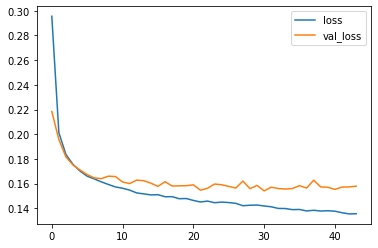

In [12]:
import matplotlib.pyplot as plt 
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.legend()
plt.show()

#56 
#53
#58 
#43 

In [13]:
valores = model.predict(X_train) #predict(X_test)
pred = scaler.inverse_transform(valores)
y_t = scaler.inverse_transform(y_train)
y_t = pd.DataFrame.from_records(y_train)
y_t = y_t.rename(columns={0:'Real'})
predito = pd.DataFrame.from_records(pred)
predito = predito.rename(columns={0:'Predito'})

In [14]:
y_train2 = y_train2[['VL_MED_FAM']]

In [15]:
resultados = pd.concat([predito, pd.Series(y_train2.VL_MED_FAM.to_list(), name='real')], axis=1)
resultados['residuo'] = resultados.real - resultados.Predito

In [17]:
valoresteste = model.predict(X_test) #predict(X_test)
predteste = scaler.inverse_transform(valoresteste)
y_tt = scaler.inverse_transform(y_test)
y_tt = pd.DataFrame.from_records(y_test)
y_tt = y_tt.rename(columns={0:'Real'})
pdteste = pd.DataFrame.from_records(predteste)
pdteste = pdteste.rename(columns={0:'Predito'})

In [18]:
y_test2 = y_test2[['VL_MED_FAM']]

In [19]:
resultadosteste = pd.concat([pdteste, pd.Series(y_test2.VL_MED_FAM.to_list(), name='real')], axis=1)
resultadosteste['residuo'] = round(resultadosteste.real - resultadosteste.Predito,2)

In [22]:
resultadosteste.head(20)

,Predito,real,residuo
0,45.453403,62,16.55
1,-1.964078,0,1.96
2,477.335724,477,-0.34
3,109.862015,484,374.14
4,209.537308,190,-19.54
5,954.788269,954,-0.79
6,52.047489,50,-2.05
7,124.529205,125,0.47
8,76.679382,83,6.32
9,74.811096,40,-34.81


## <font color=red> Perfomance </font>

In [23]:
from sklearn.metrics import mean_absolute_error
from sklearn.utils.validation import check_array
print(mean_absolute_error(resultados.real,resultados.Predito))
print(mean_absolute_error(resultadosteste.real,resultadosteste.Predito))


55.16175622262865
61.66187224853889


(array([4.8200e+02, 2.4000e+01, 7.7500e+02, 5.1900e+02, 2.9660e+03,
        7.7152e+04, 2.9180e+03, 2.1230e+03, 4.0900e+02, 2.3800e+02,
        6.1800e+02, 5.0000e+01, 3.7000e+01, 2.6000e+01, 2.3000e+01,
        1.4000e+01, 2.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([-961.77490234, -779.61460037, -597.4542984 , -415.29399643,
        -233.13369446,  -50.97339249,  131.18690948,  313.34721146,
         495.50751343,  677.6678154 ,  859.82811737, 1041.98841934,
        1224.14872131, 1406.30902328, 1588.46932526, 1770.62962723,
        1952.7899292 , 2134.95023117, 2317.11053314, 2499.27083511,
        2681.43113708]),
 <a list of 20 Patch objects>)

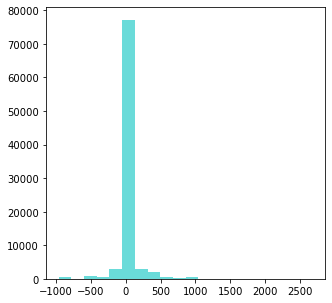

In [25]:
import matplotlib.pyplot as plt 
plt.subplots(1,1,figsize=(5,5))
plt.hist(resultados.residuo, color='#6ADBD9', bins=20)

(array([2.100e+02, 9.000e+00, 1.500e+01, 4.280e+02, 3.170e+02, 7.890e+02,
        3.163e+04, 1.925e+03, 9.780e+02, 5.560e+02, 4.950e+02, 1.150e+02,
        9.500e+01, 2.580e+02, 9.000e+00, 1.200e+01, 5.000e+00, 6.000e+00,
        1.600e+01, 9.000e+00]),
 array([-958.38  , -815.1425, -671.905 , -528.6675, -385.43  , -242.1925,
         -98.955 ,   44.2825,  187.52  ,  330.7575,  473.995 ,  617.2325,
         760.47  ,  903.7075, 1046.945 , 1190.1825, 1333.42  , 1476.6575,
        1619.895 , 1763.1325, 1906.37  ]),
 <a list of 20 Patch objects>)

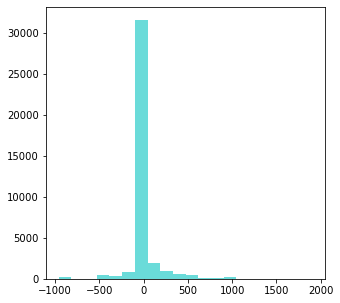

In [26]:
import matplotlib.pyplot as plt 
plt.subplots(1,1,figsize=(5,5))
plt.hist(resultadosteste.residuo, color='#6ADBD9', bins=20)